In [1]:
import numpy as np
from PIL import Image
from PIL import ImageDraw
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform
from skimage.feature import canny
from skimage.filters import sobel
from copy import copy
import pydicom as pdcm
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
get_ipython().magic('matplotlib inline')

In [2]:
def flipImage(img):
    leftCount = []
    rightCount = []
    for row in range(img.shape[0]):
        leftCount.append(img[row][0:int(img.shape[1]/2)])
        rightCount.append(img[row][int(img.shape[1]/2):img.shape[1]-1])
    left = np.mean(leftCount)
    right = np.mean(rightCount)
    if right > left:
        img = np.fliplr(img)
    
    return img

In [37]:
def vertBarRemoval(ogimg):
    img = copy(ogimg)
    newIm = np.rot90(img,3)
    row = 0
    while row < newIm.shape[0]:
        if np.mean(newIm[row]) >= 240:
            newIm = newIm[row+1:newIm.shape[0]]
        else:
            row += 1
        
    newIm = skimage.transform.resize(np.rot90(newIm), (224,224))
    return newIm

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [5]:
def backgroundRemoval(ogimg):
    img = copy(ogimg)
    
    row = 0
    endPoints = []
    while row < img.shape[0]:
        for col in range(img.shape[1]):
            if img[row][col] == 0 and col > img.shape[1]/4:
                endPoints.append((col, row))
                break
                
        row += 1
        
    x_val = [x[0] for x in endPoints]
    y_val = [x[1] for x in endPoints]
    sx = smooth(np.asarray(x_val),15)
    sx = sx[round((len(sx)-len(x_val))/2):round((len(sx)-(len(sx)-len(x_val))/2))]
    
    for i, el in enumerate(y_val):
        for col in range(img.shape[1]):
            if col > sx[i]:
                img[el][col] = 0
        
    return img

In [83]:
def horizBarRemoval(ogimg):
    newIm = copy(ogimg)
    row = 0
    while row < newIm.shape[0]:
        rowMean = np.mean(newIm[row])
        rowHalfStd = np.std(newIm[row][0:round(newIm.shape[1]/2)])
        rowEdgeDiff = abs(np.mean(newIm[row][0:10]) - np.mean(newIm[row][-11:-1]))
        if rowMean > 80 and rowEdgeDiff < 100:
            if row < img.shape[0]/2:
                newIm = newIm[row+1:newIm.shape[0]]
            else:
                newIm[row] = np.zeros(newIm.shape[1])
                row += 1
        elif rowMean > 100 and rowHalfStd < 10:
            if row < img.shape[0]/2:
                newIm = newIm[row+1:newIm.shape[0]]
            else:
                newIm[row] = np.zeros(newIm.shape[1])
                row += 1
        else:
            row +=1
        
    newIm = skimage.transform.resize(newIm, (224,224))
    return newIm

In [150]:
def cannyCrop(img, canNum):
    canIm = canny(img, canNum) # Do canny transform (Find Which canny # to use) **
    newIm = copy(img) # Coppy to crop at end of function
    
    # Finds all instances of non-false pixels in the canny image
    lineList = []
    for row in range(canIm.shape[0]):
        tempList = []
        for col in range(canIm.shape[1]):
            if canIm[row][col] == True:
                tempList.append(col)
        lineList.append(tempList)
    
    # Finds all instances of pixels part of continuous line from previous lists
    newlineList = []
    i = 0
    while i < len(lineList):
        tempList = []
        for num in lineList[i]:
            if num in lineList[i+1] or num-1 in lineList[i+1]:
                tempList.append(num)

        newlineList.append(tempList)
        i += 1
        
    # Finds first non-empty row to find starting points for lines to select
    rowNum = 0
    for row in newlineList:
        if row != []:
            starterRow = row
            break
            
        rowNum += 1
    
    # Populate dictionary with line starting point and line path
    lineDict = {}
    for el in starterRow:
        lineDict.update({el:[el]})
    
    # Fill line path if within max of 2 to the left and right of last pixel position
    # allowing 1 pixel gap down/up
    
    i = rowNum + 1
    while i < len(newlineList)-1:
        #print(i)
        for lineList in list(lineDict.values()):
            if lineList[-1] != -1:
                if lineList[-1]-2 in newlineList[i]:
                    lineList.append(lineList[-1]-2)            
                elif lineList[-1]-1 in newlineList[i]:
                    lineList.append(lineList[-1]-1)            
                elif lineList[-1] in newlineList[i]:
                    lineList.append(lineList[-1])
                elif lineList[-1]+1 in newlineList[i]:
                    lineList.append(lineList[-1]+1)
                elif lineList[-1]+2 in newlineList[i]:
                    lineList.append(lineList[-1]+2)
                elif lineList[-1]-2 in newlineList[i+1]:
                    lineList.append(lineList[-1]-2)            
                elif lineList[-1]-1 in newlineList[i+1]:
                    lineList.append(lineList[-1]-1)            
                elif lineList[-1] in newlineList[i+1]:
                    lineList.append(lineList[-1])
                elif lineList[-1]+1 in newlineList[i+1]:
                    lineList.append(lineList[-1]+1)
                elif lineList[-1]+2 in newlineList[i+1]:
                    lineList.append(lineList[-1]+2)
                else:
                    lineList.append(-1) # end of line condition
        if 0 == len(lineDict):
            break # if all lines are finished, end looping
        i += 1
    
    # Find longest such line (what if i want line that isnt longest??) **
    maxVal = 0
    for key in list(lineDict.keys()):
        if len(lineDict[key]) > maxVal and int(key) < img.shape[0]/2:
            maxKey = key
            maxVal = len(lineDict[key])
        
    # Remove '-1' from end of list
    line = lineDict[maxKey][0:-2]
    # Make line same length as image
    for i in range(canIm.shape[0]):
        if i < rowNum:
            line = [line[0]] + line
        elif i >= len(line):
            line.append(0)
    
    smline = smooth(np.asarray(line))
    smline = smline[round((len(smline)-len(line))/2):]
    line = smline[:img.shape[0]]
    
    # Removes all pixels from left of line
    for row in range(newIm.shape[0]):
        cutOff = line[row]
        for col in range(newIm.shape[1]):
            if col <= cutOff:
                newIm[row][col] = -1
        
        
    return newIm

In [62]:
np.std()

nan

In [133]:
image_name = 'Calc-Test_P_00132_LEFT_MLO'
image_path = 'D:/DDSM_Clean/Calc_Test/' + image_name

In [139]:
im = pdcm.dcmread(image_path)
im = im.pixel_array
im = skimage.transform.resize(im, (224,224))
im = flipImage(im*255)

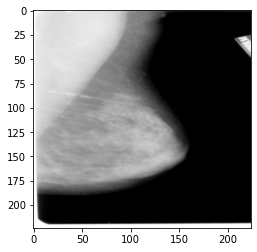

In [140]:
plt.imshow(im, cmap='gray')

In [145]:
newIm = horizBarRemoval(backgroundRemoval(flipImage(im)))

{8: [8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, -1], 9: [9, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, -1], 35: [35, 36, 36, 37, 37, 37, 37, 38, 38, -1], 36: [36, 36, 36, 37, 37, 37, 37, 38, 38, -1], 94: [94, 94, 93, 93, 93, 93, 93, 93, 93, 93, 93, 92, 92, 92, 92, 92, 92, 91, 91, 91, 90, 90, 90, 89, 89, 89, 88, 88, 87, 87, 86, 86, 85, 85, 84, 84, 83, 83, 82, 81, 80, 80, 79, 78, 77, 77, 76, 75, 74, 73, 73, 72, 71, 70, 69, 68, 68, 67, 66, 65, 64, 63, 63, 62, 61, 60, 59, 59, 58, 57, 56, 55, 54, 54, 53, 52

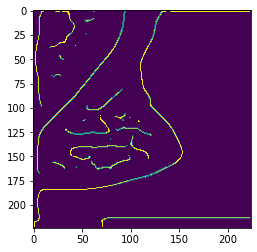

In [146]:
newIm = cannyCrop(newIm, 6)

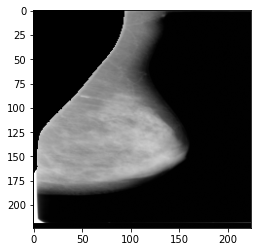

In [147]:
plt.imshow(newIm, cmap='gray')

In [148]:
def makeLabel(im_path):
    im = pdcm.dcmread(im_path)
    im = im.pixel_array
    im = skimage.transform.resize(im, (224,224))
    im = im*255
    
    newIm = cannyCrop(horizBarRemoval(backgroundRemoval(flipImage(im))), 6)
    
    for row in range(newIm.shape[0]):
        for col in range(newIm.shape[1]):
            if newIm[row][col] == -1:
                newIm[row][col] = 1
            elif newIm[row][col] > 0:
                newIm[row][col] = 2
                
    return newIm

Calc-Test_P_00038_LEFT_MLO


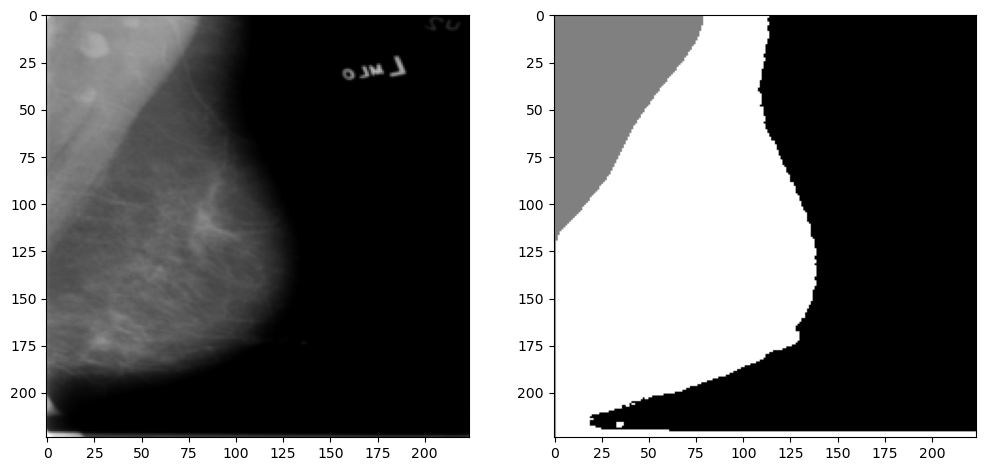

Calc-Test_P_00038_RIGHT_MLO


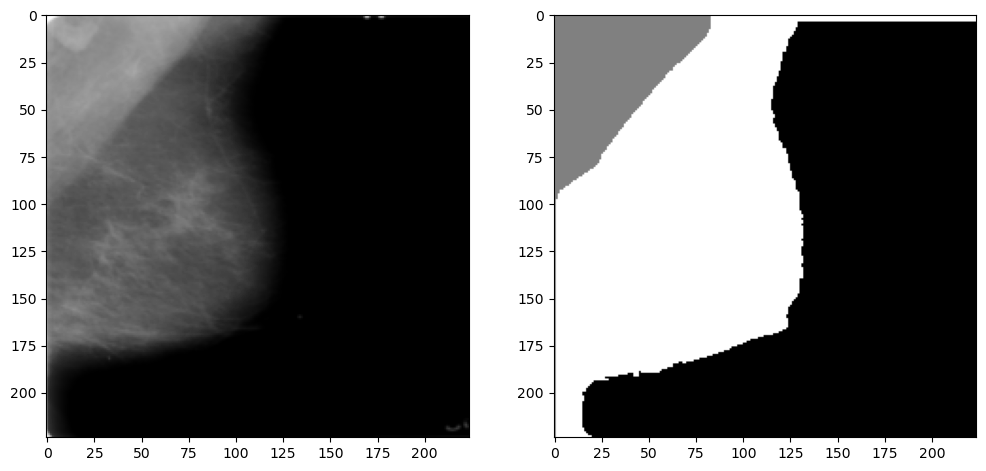

Calc-Test_P_00041_LEFT_MLO


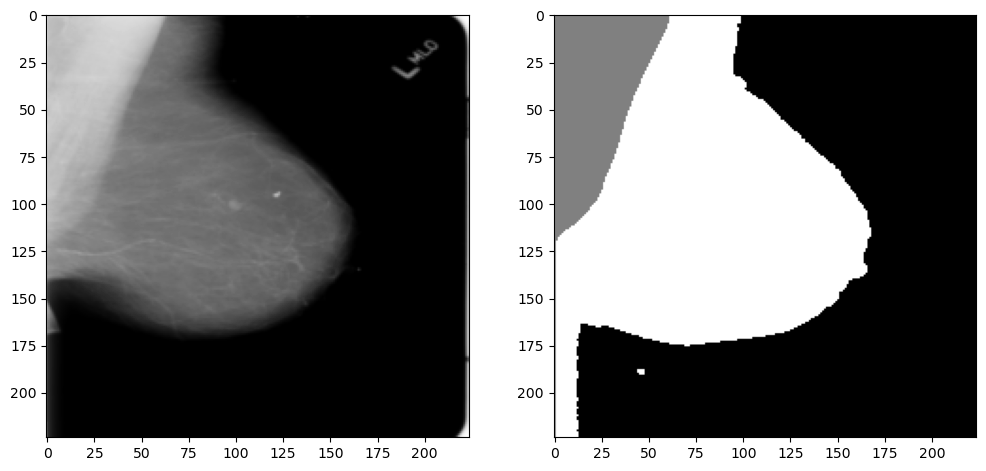

Calc-Test_P_00077_LEFT_MLO


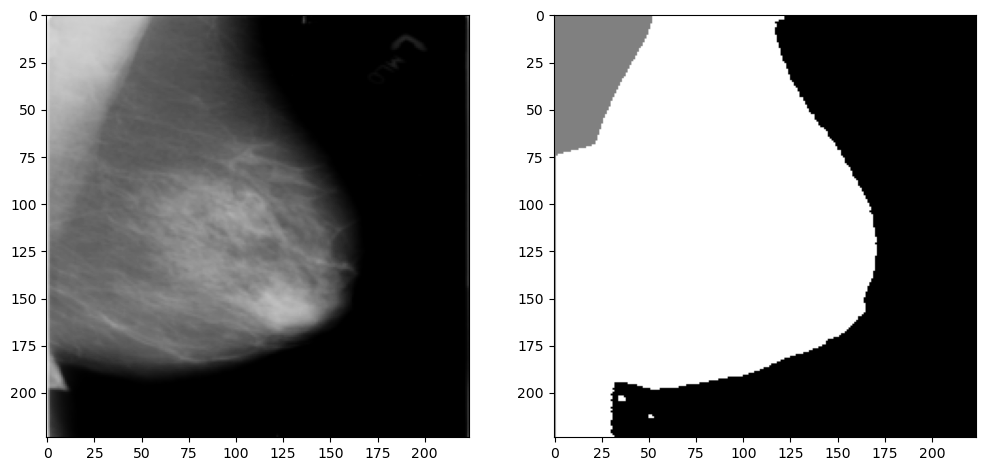

Calc-Test_P_00077_RIGHT_MLO


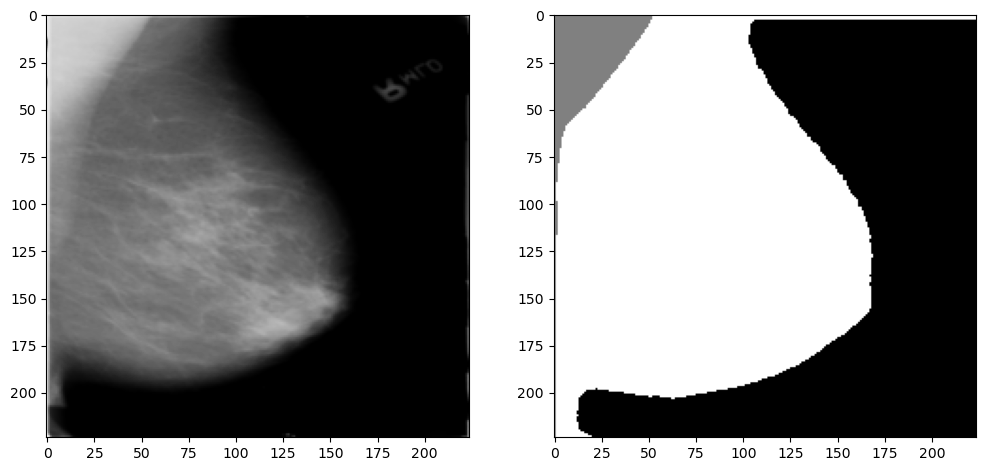

Calc-Test_P_00100_RIGHT_MLO


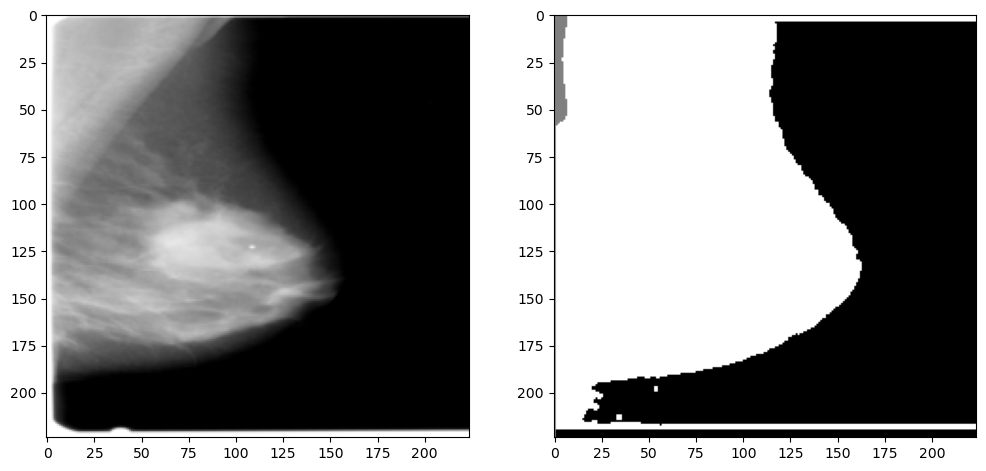

Calc-Test_P_00127_RIGHT_MLO


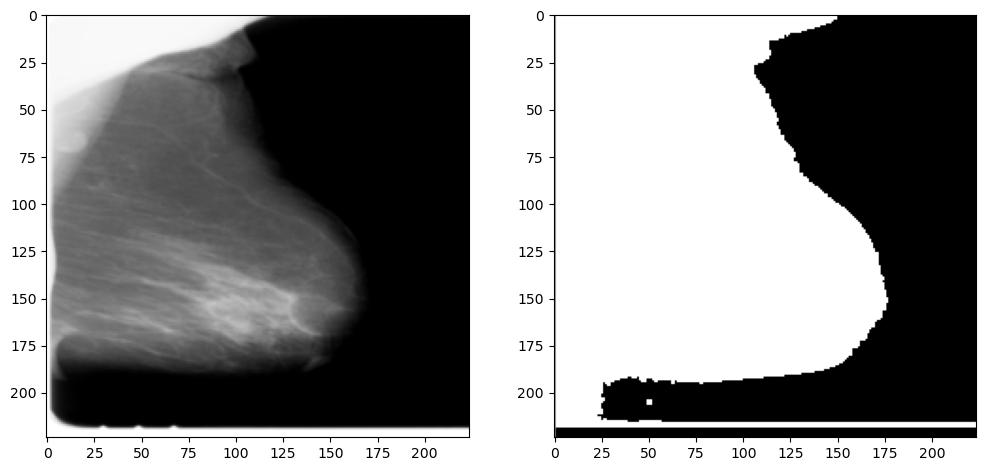

Calc-Test_P_00132_LEFT_MLO


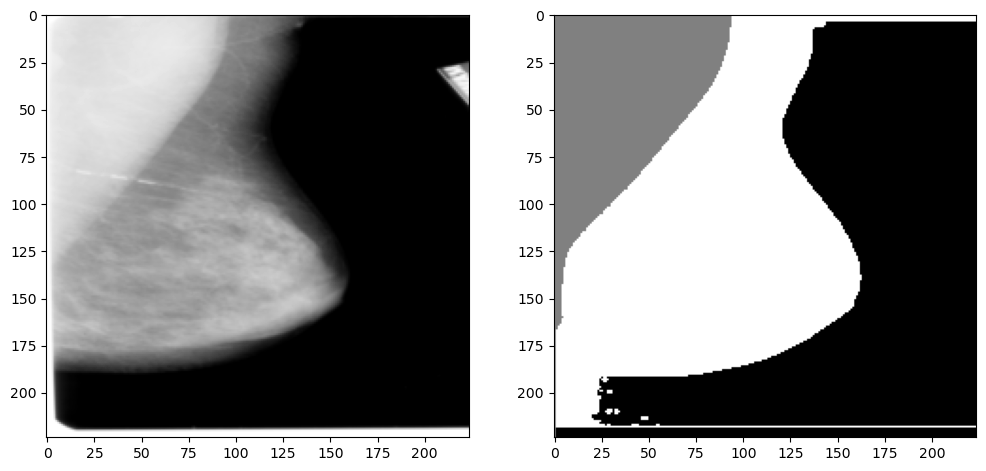

Calc-Test_P_00140_LEFT_MLO


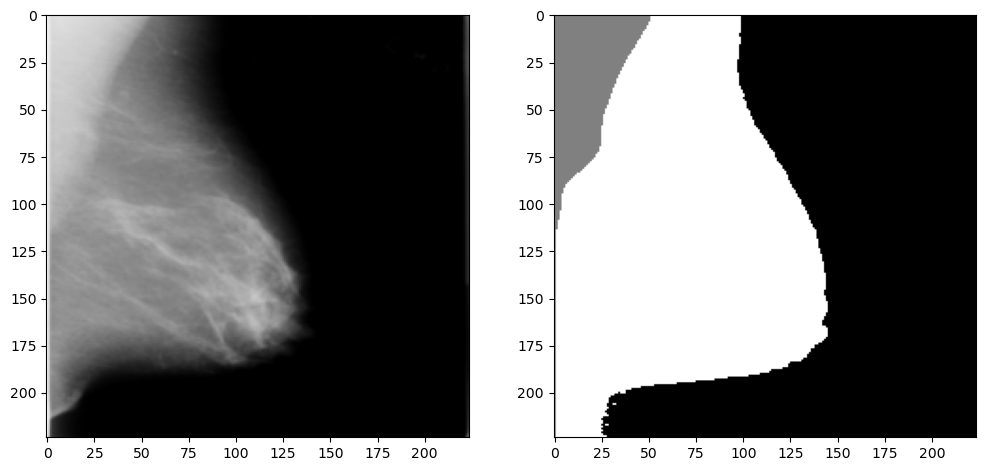

Calc-Test_P_00140_RIGHT_MLO


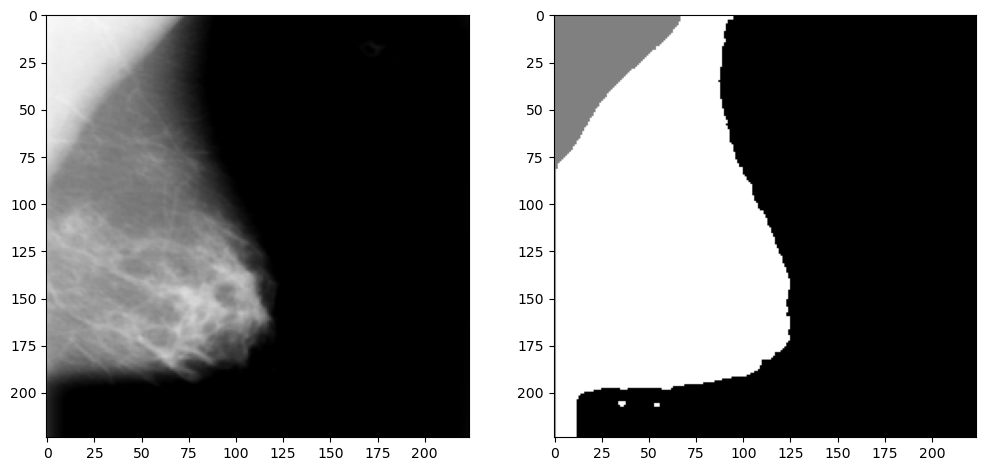

Calc-Test_P_00141_LEFT_MLO


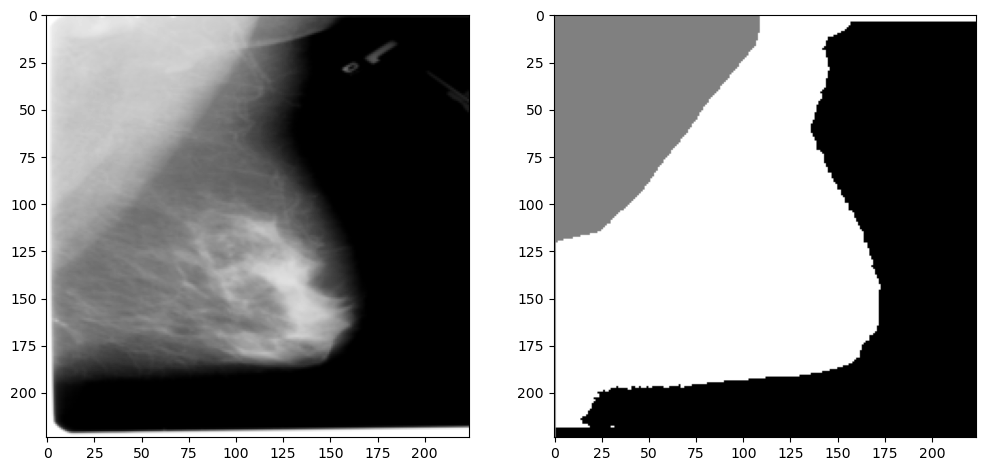

Calc-Test_P_00150_RIGHT_MLO


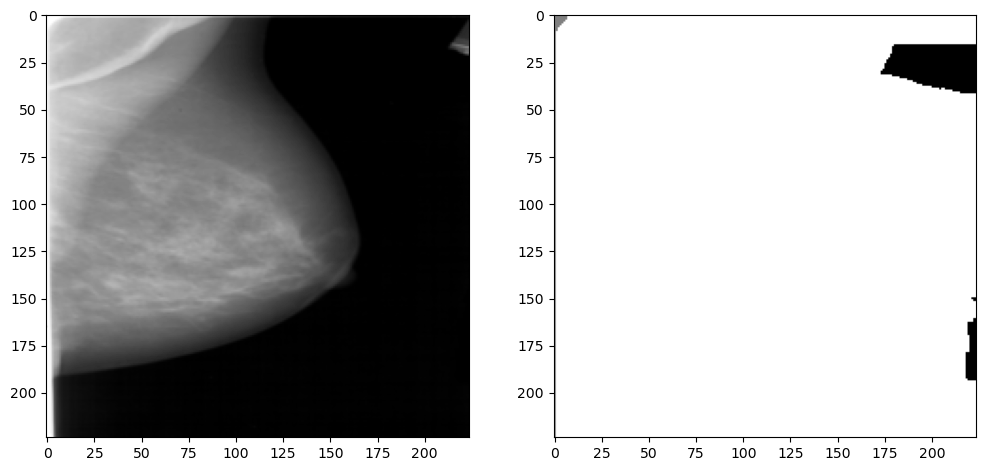

Calc-Test_P_00163_LEFT_MLO


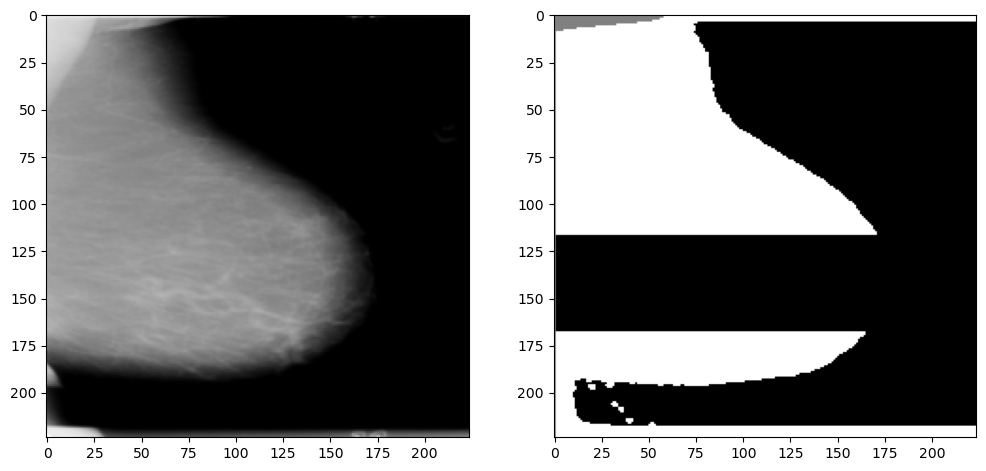

Calc-Test_P_00180_LEFT_MLO


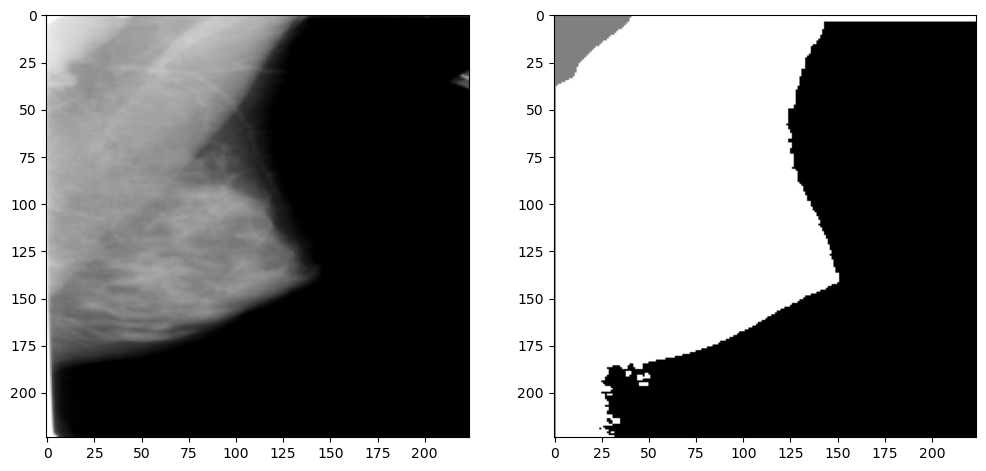

Calc-Test_P_00195_LEFT_MLO


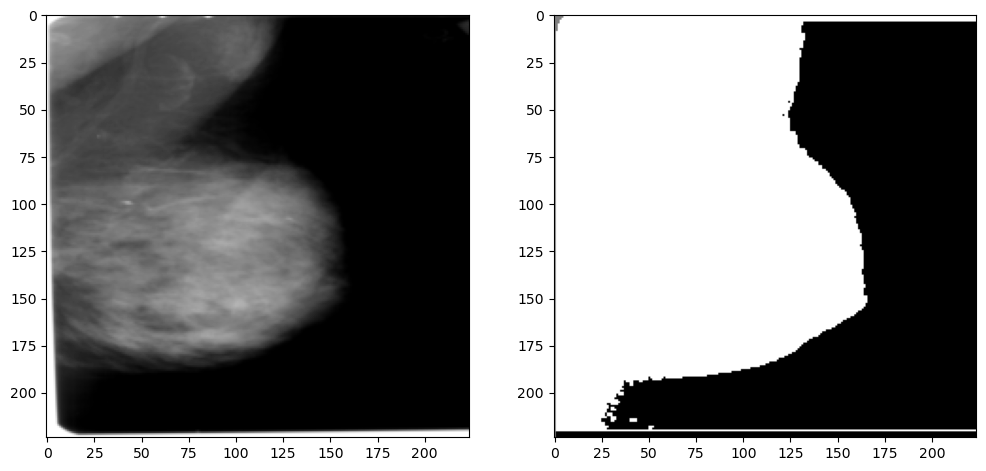

Calc-Test_P_00202_RIGHT_MLO


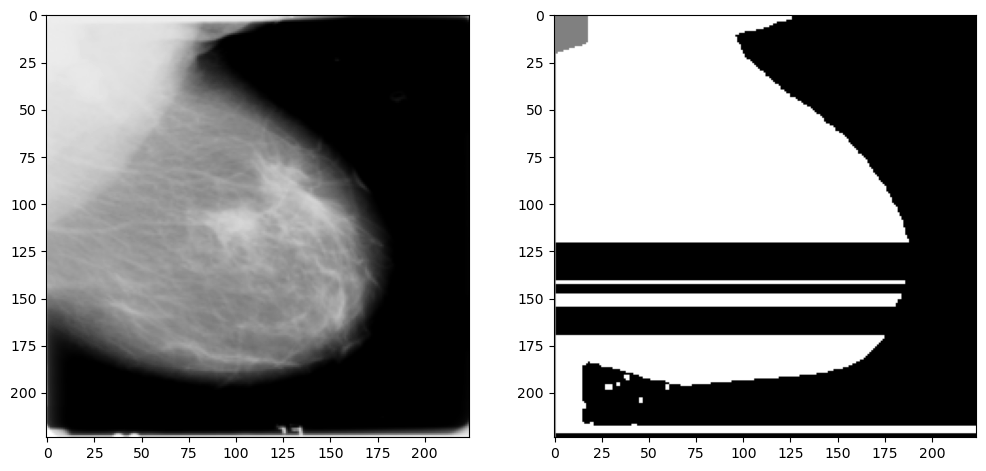

Calc-Test_P_00214_LEFT_MLO


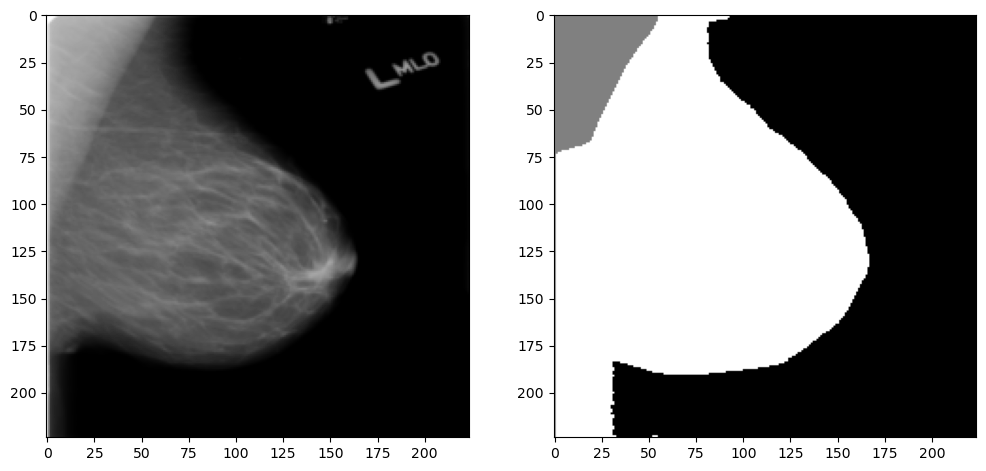

Calc-Test_P_00214_RIGHT_MLO


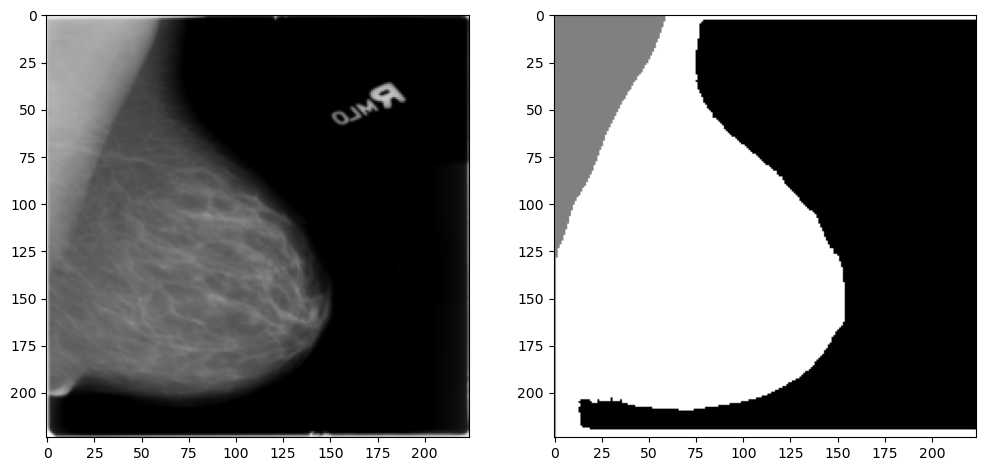

Calc-Test_P_00223_LEFT_MLO


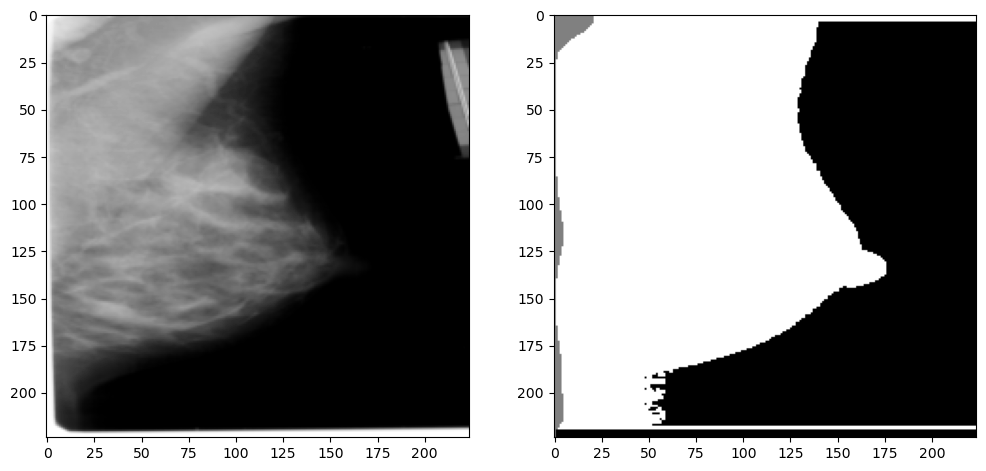

Calc-Test_P_00244_RIGHT_MLO


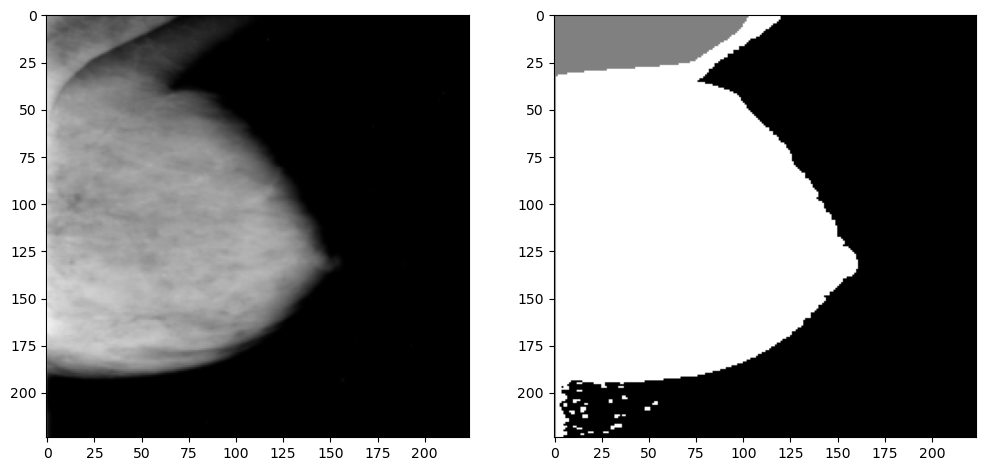

Calc-Test_P_00246_RIGHT_MLO


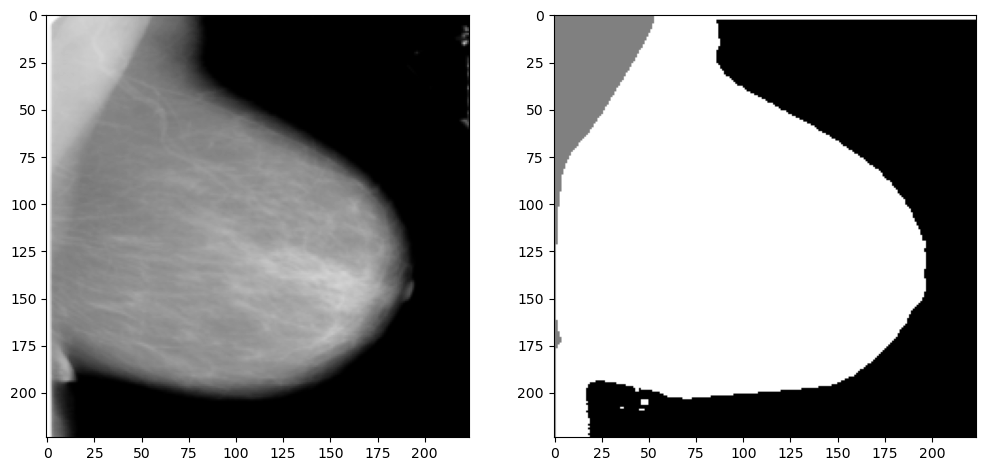

Calc-Test_P_00257_RIGHT_MLO


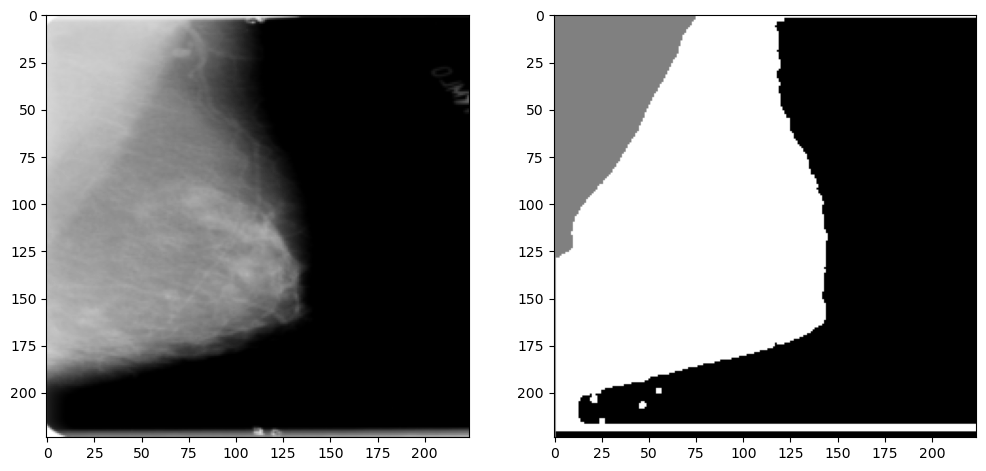

Calc-Test_P_00299_LEFT_MLO


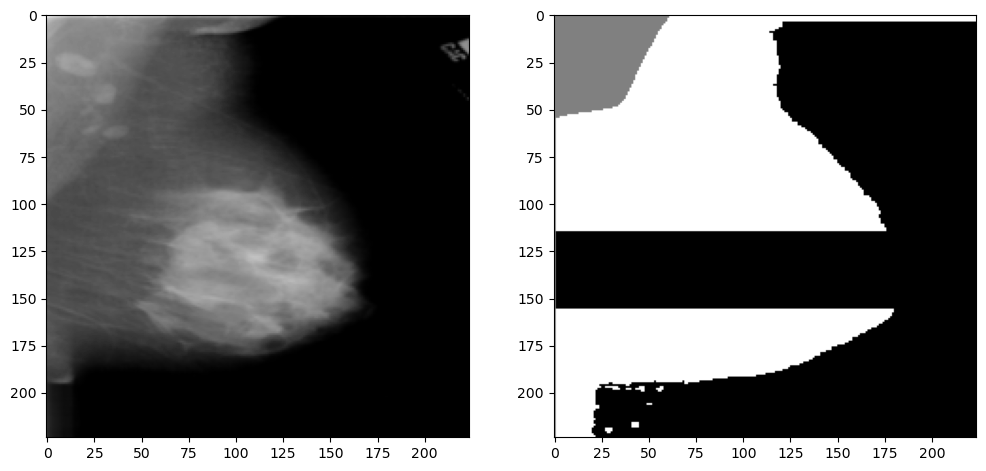

Calc-Test_P_00299_RIGHT_MLO


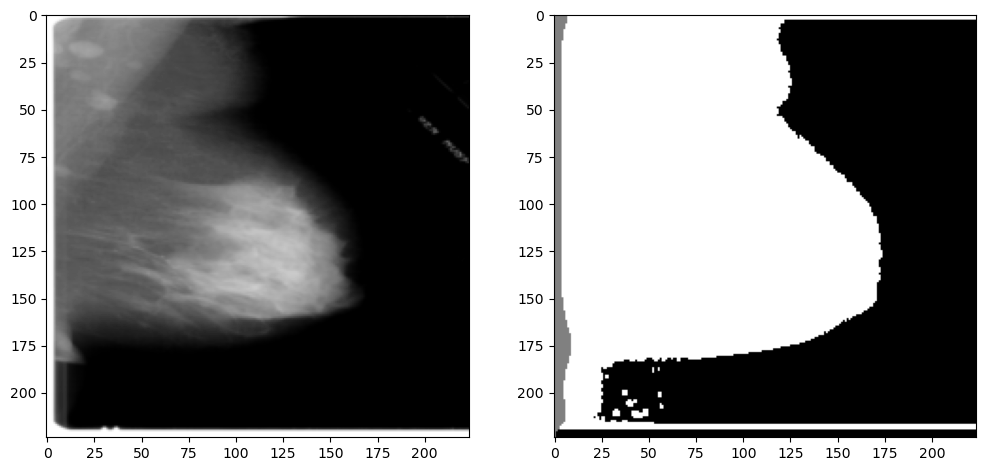

Calc-Test_P_00315_LEFT_MLO


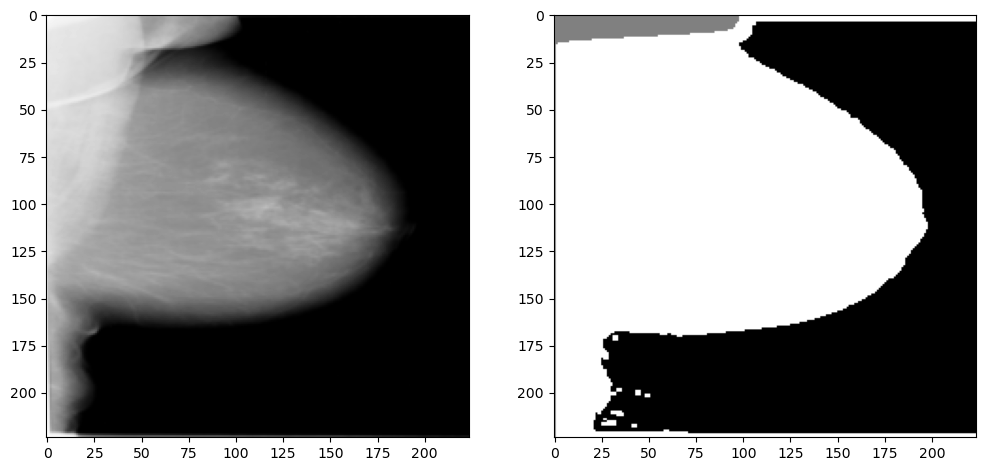

Calc-Test_P_00325_RIGHT_MLO


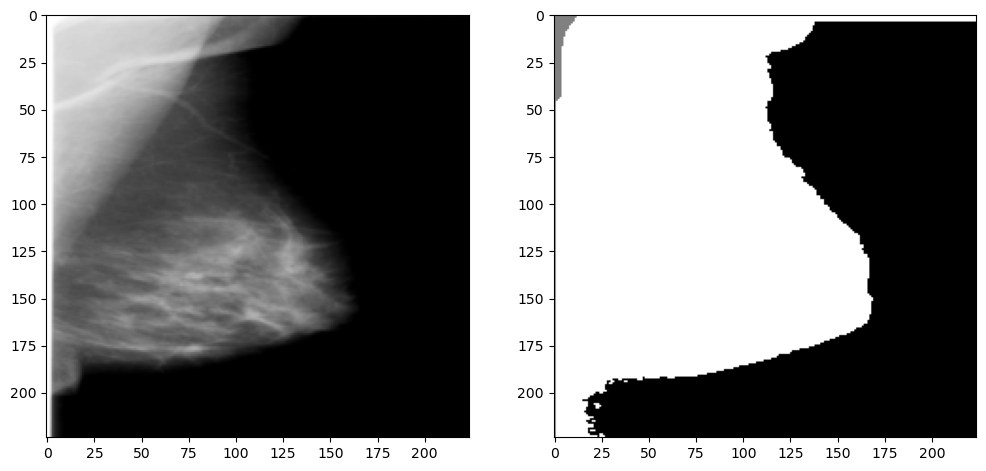

Calc-Test_P_00331_LEFT_MLO


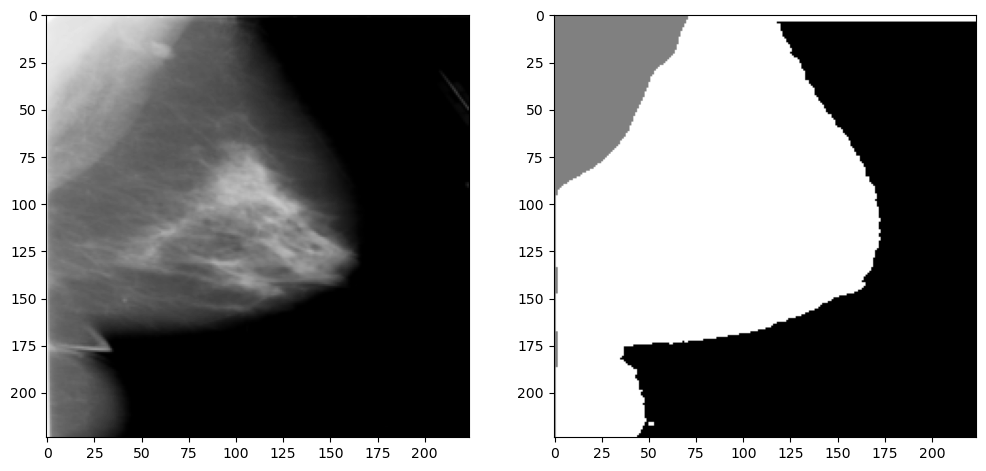

Calc-Test_P_00344_LEFT_MLO


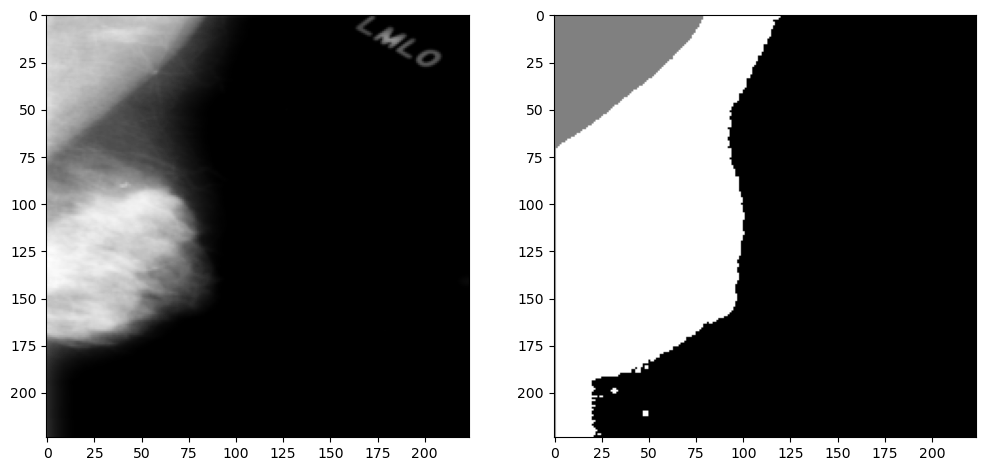

Calc-Test_P_00352_LEFT_MLO


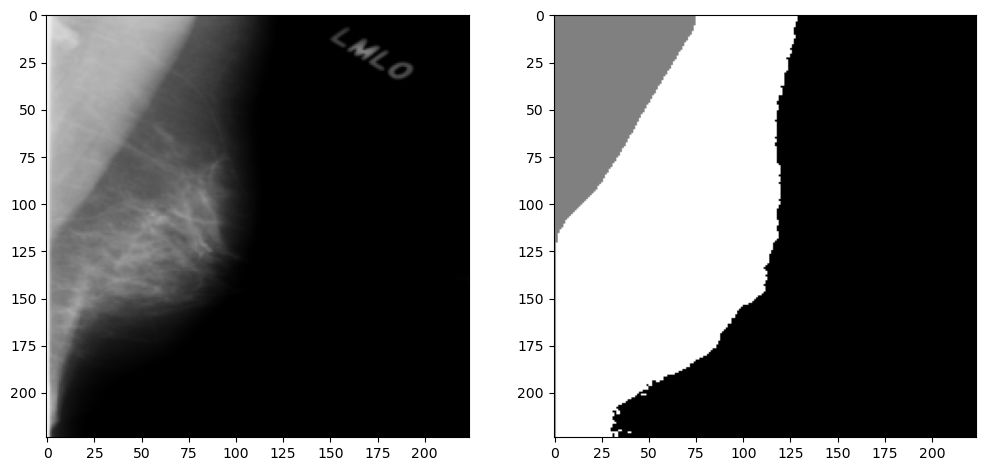

Calc-Test_P_00353_LEFT_MLO


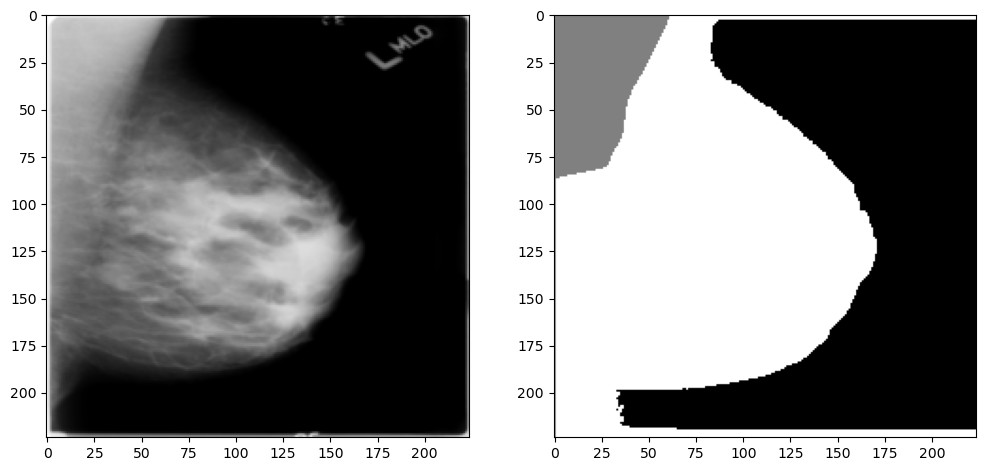

Calc-Test_P_00368_LEFT_MLO


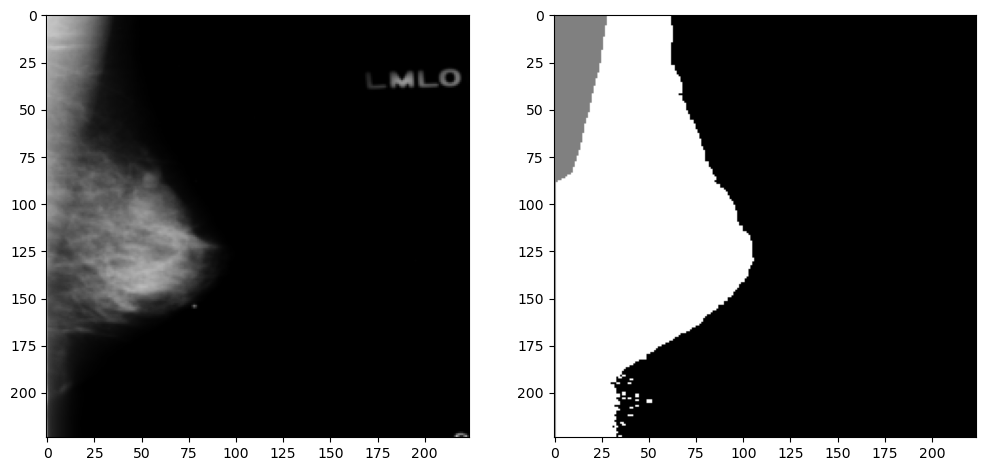

Calc-Test_P_00372_RIGHT_MLO


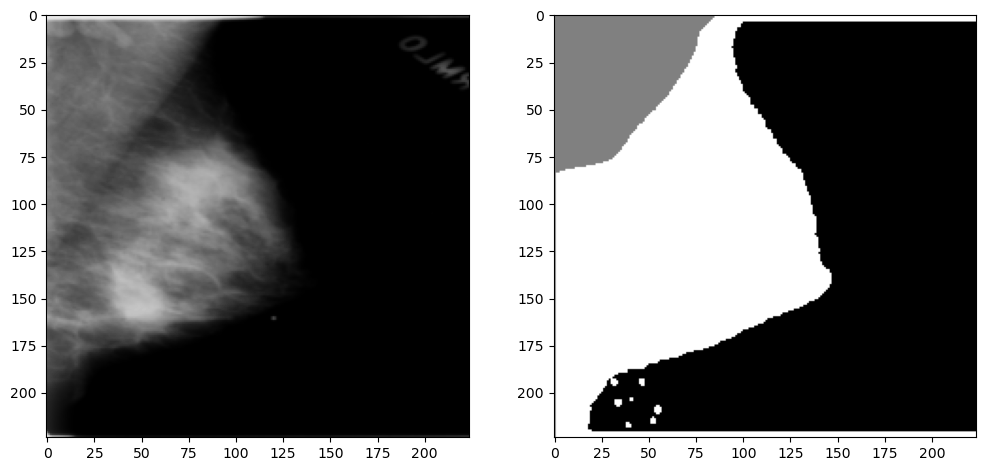

Calc-Test_P_00390_RIGHT_MLO


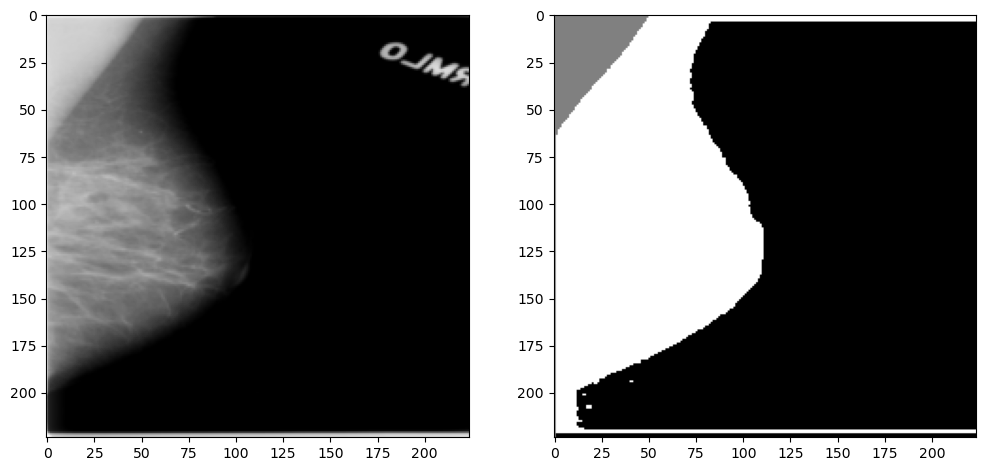

Calc-Test_P_00402_RIGHT_MLO


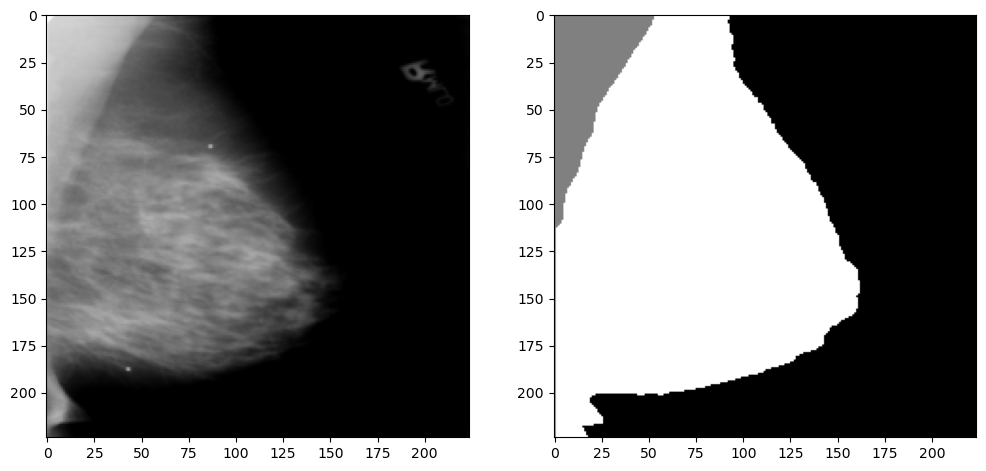

Calc-Test_P_00403_RIGHT_MLO


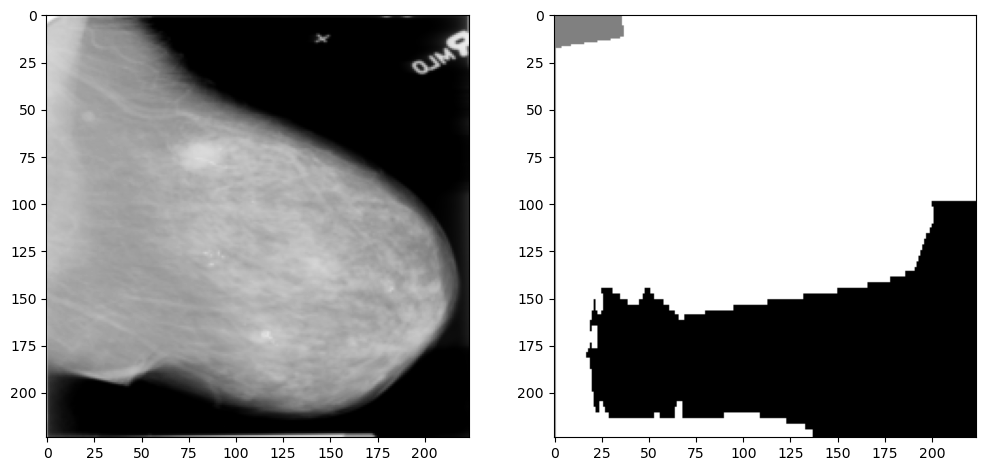

Calc-Test_P_00460_LEFT_MLO


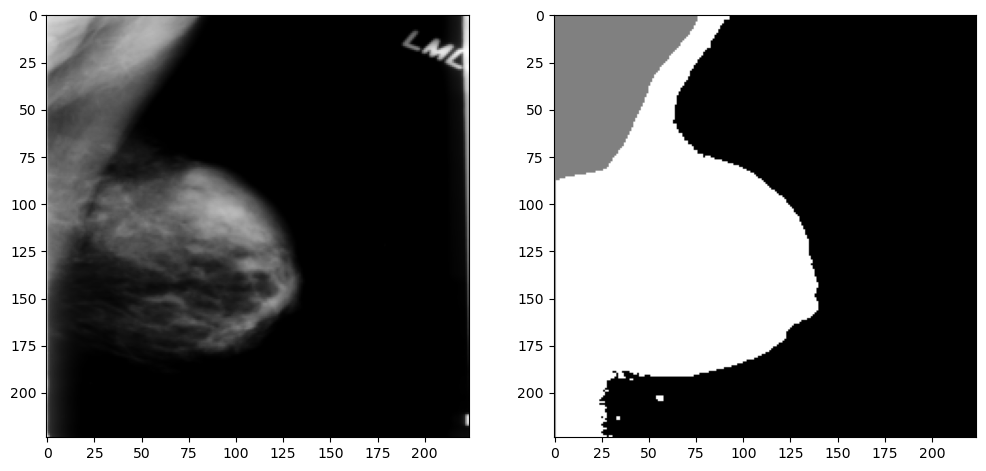

Calc-Test_P_00466_LEFT_MLO


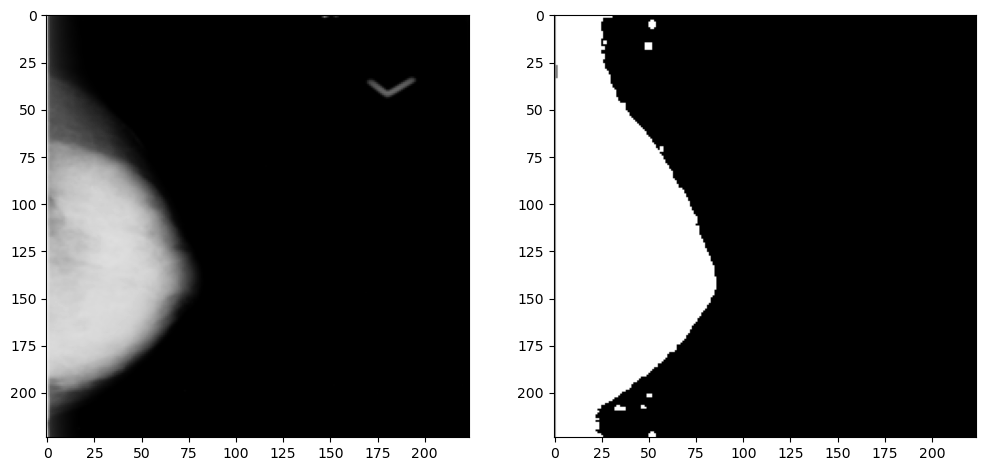

Calc-Test_P_00485_LEFT_MLO


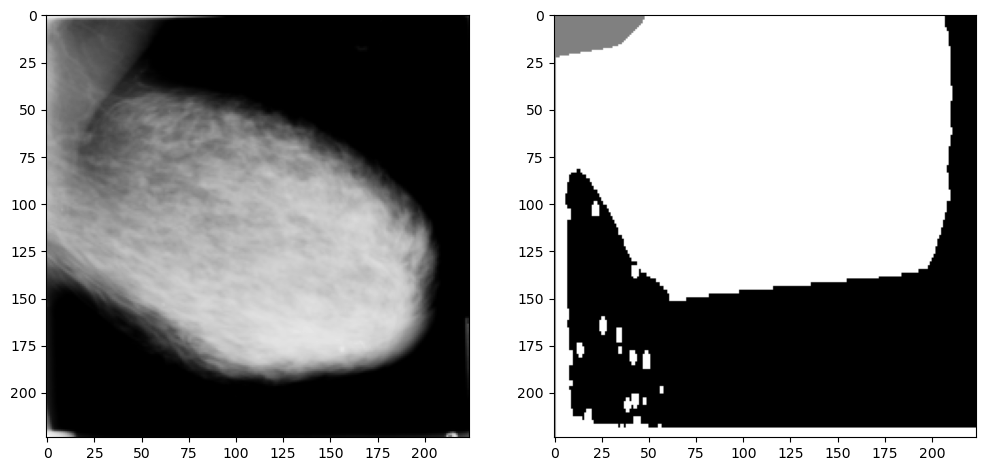

Calc-Test_P_00495_RIGHT_MLO


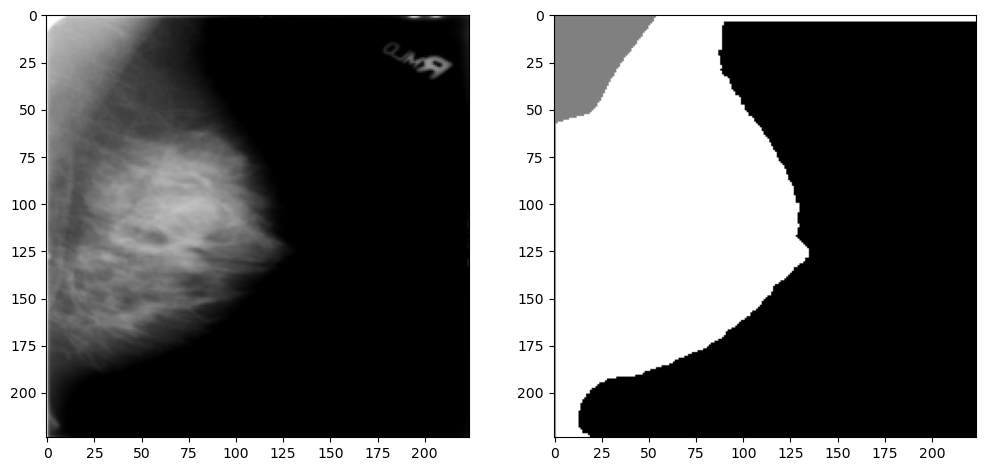

Calc-Test_P_00497_LEFT_MLO


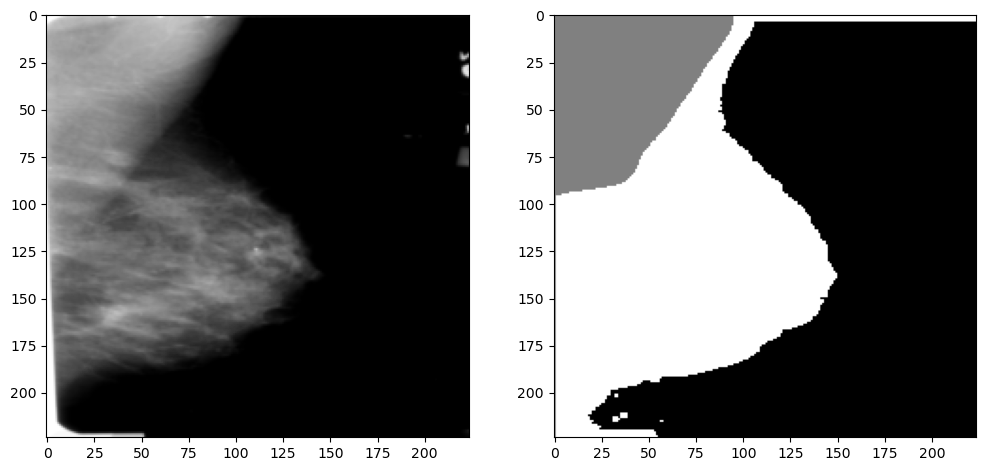

Calc-Test_P_00537_RIGHT_MLO


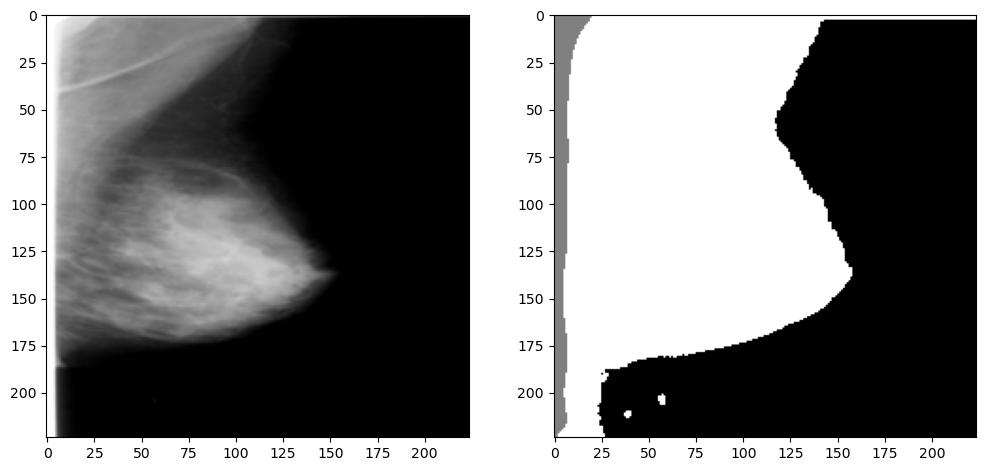

Calc-Test_P_00562_LEFT_MLO


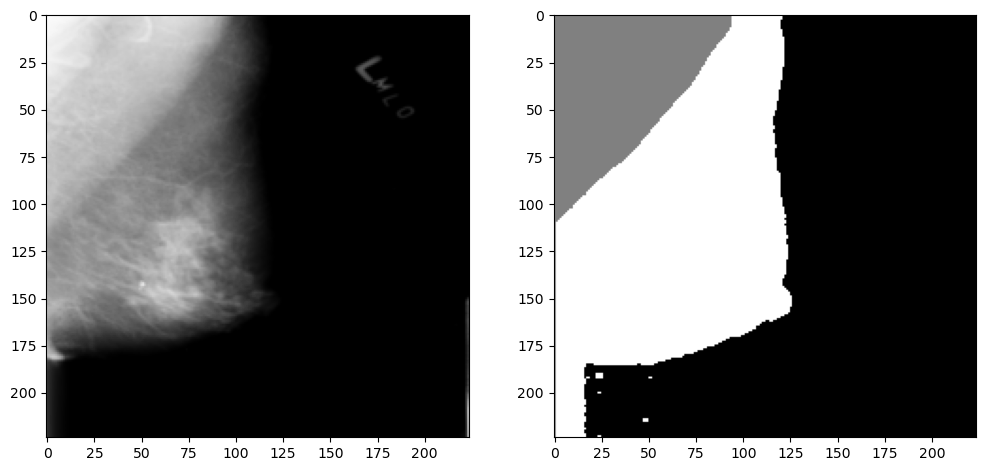

Calc-Test_P_00562_RIGHT_MLO


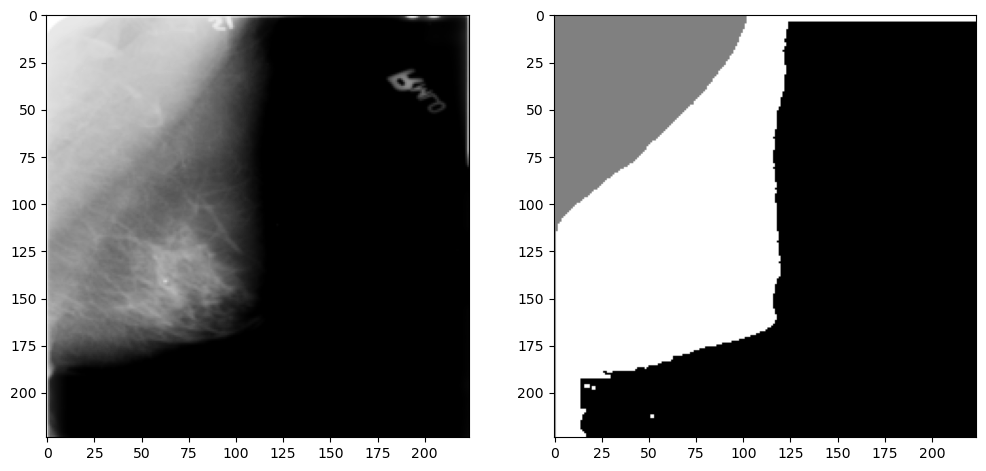

Calc-Test_P_00570_LEFT_MLO


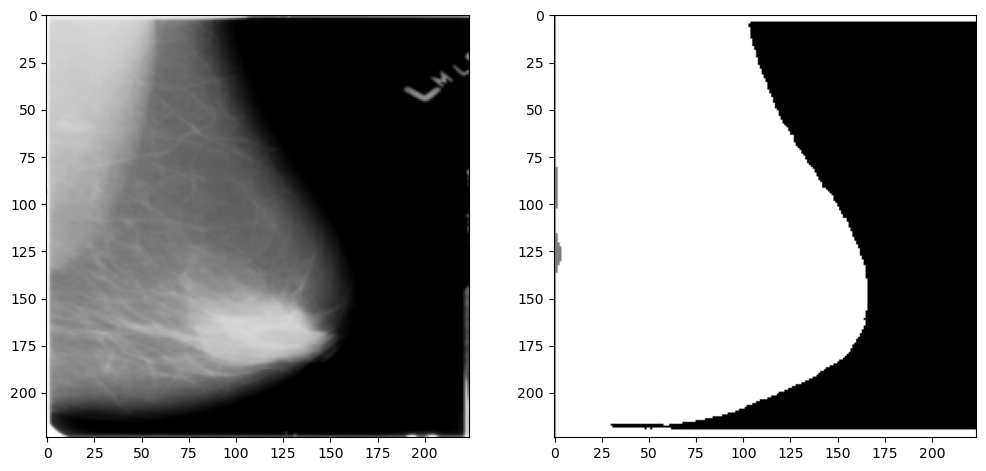

Calc-Test_P_00579_LEFT_MLO


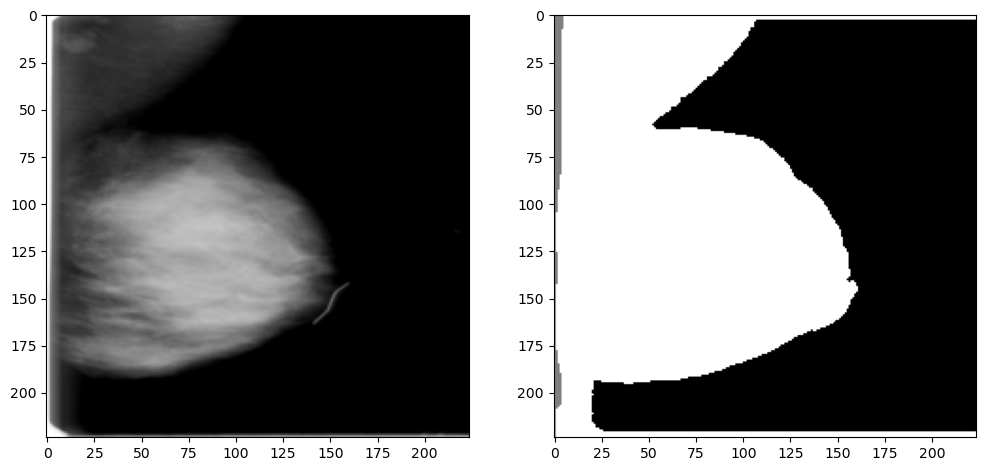

Calc-Test_P_00589_LEFT_MLO


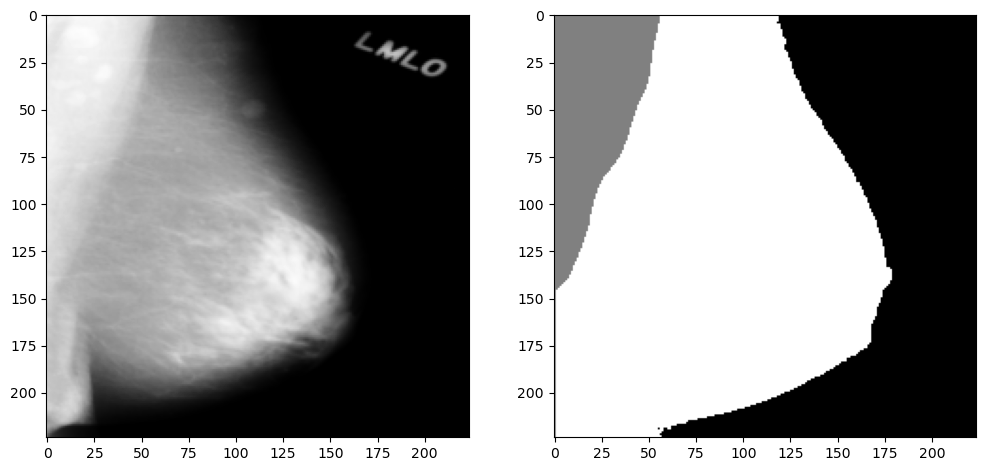

Calc-Test_P_00608_LEFT_MLO


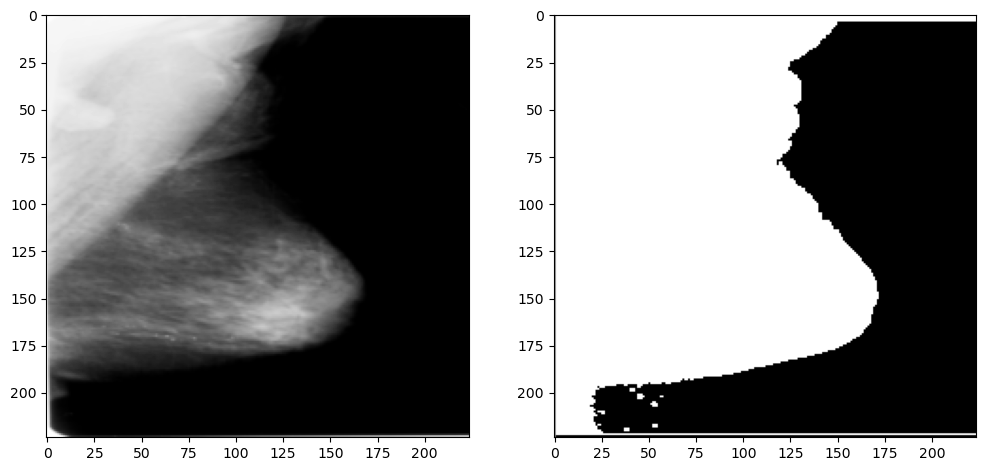

Calc-Test_P_00643_LEFT_MLO


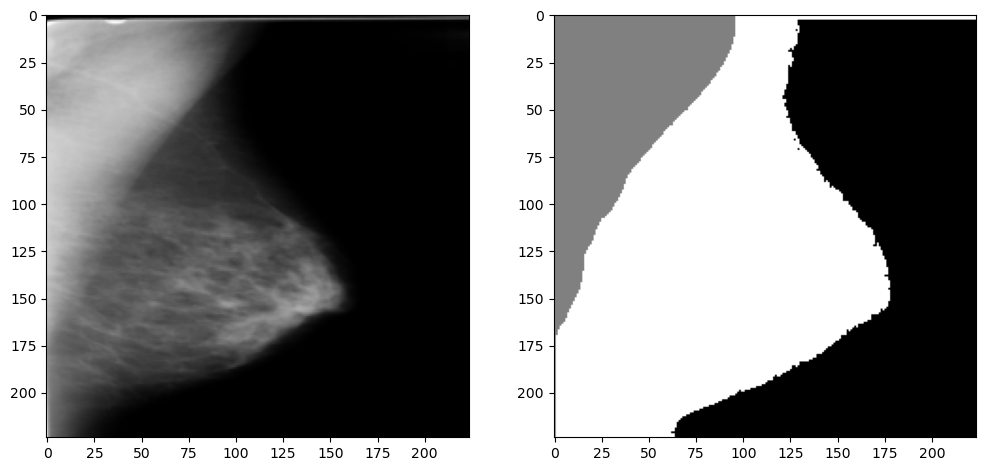

Calc-Test_P_00646_LEFT_MLO


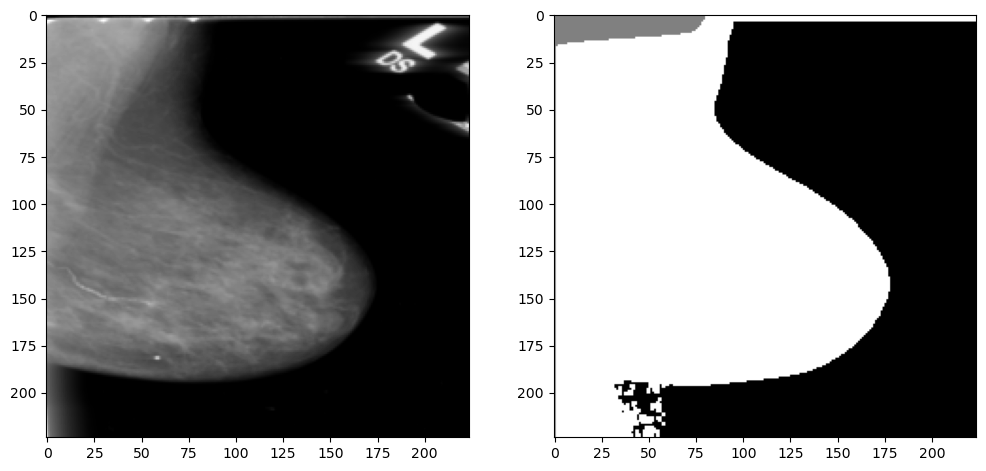

Calc-Test_P_00649_LEFT_MLO


UnboundLocalError: local variable 'maxKey' referenced before assignment

In [152]:
for file in os.listdir('D:/DDSM_Clean/Calc_Test/'):
    if "CC" not in file:
        print(file)
        image_path = 'D:/DDSM_Clean/Calc_Test/' + file
        im = pdcm.dcmread(image_path)
        im = im.pixel_array
        im = skimage.transform.resize(im, (224,224))
        im = im*255
        img = makeLabel(image_path)
        fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.imshow(flipImage(im), cmap='gray')
        plt.subplot(1,2,2)
        plt.imshow(img, cmap='gray')
        plt.show()